# Zoning and Affordable Housing in the City of Austin




# **Background**

The affordable housing crisis in the United States has recentered the issue of land-use designation in urban policy discourse. The pervasiveness of single-family zones, zones which restrict development to single-unit dwellings, creates a scarcity for lots which can be developed for multi-unit, affordable housing. 

This project explores the relationship between land-use designations and the presence of affordable housing in the city of Austin. I chose Austin primarily because it's data was easily accessible, but it also makes for a good case study due to its rapid growth over the past decade. The main question I want to answer is *how does the proportion of single-family zoning in a given zip code relate to the quantity of affordable housing units?*

# **Data Overview**

The two main datasets used in the analysis are both from the City of Austin's website. The first dataset, called *zoning*, contains the zoning type for over 250,000 addresses in the city. The second dataset, called *housing*, contains the addresses and zip codes of affordable housing buildings, as well as how many total units there are in a given building. There are roughly 2,000 records in the *housing* dataset. The two datasets are joined to form one that contains the total number of units and zoning information for each zip code.

*Housing* dataset: https://data.austintexas.gov/Housing-and-Real-Estate/City-of-Austin-Affordable-Housing-Inventory/x5p7-qyuv

*Zoning* dataset: https://data.austintexas.gov/Locations-and-Maps/Zoning-by-Address/nbzi-qabm


In [2]:
library(tidyr)
library(dplyr)
library(stringr)
library(docstring)
library(ggplot2)
library(patchwork)
options(warn = -1)

In [3]:
#The Data
zoning <- read.csv("austin_zoning.csv")
housing <- read.csv("austin_affordable_housing.csv")

#Select and rename columns
zoning <- zoning %>%
    select(FULL_STREET_NAME, ZONING_ZTYPE, BASE_ZONE, BASE_ZONE_CATEGORY) %>%
    rename(address = FULL_STREET_NAME, zoning_type = ZONING_ZTYPE, base_zone = BASE_ZONE, 
            base_zone_cat = BASE_ZONE_CATEGORY)  

housing <- housing %>%
    select(Address, Zip.Code, Total.Units, Location, City.Amount) %>%
    rename(address = Address, zip_code = Zip.Code, total_units = Total.Units, loc = Location, 
           city_amt = City.Amount) 

#Zoning
head(zoning)
dim(zoning)

#Housing
head(housing)
dim(housing)

,address,zoning_type,base_zone,base_zone_cat
,<chr>,<chr>,<chr>,<chr>
1,9420 EDMUNDSBURY DR,SF-4A,SF-4A,Single Family Small Lot
2,8038 MESA DR,LR,LR,Neighborhood Commercial
3,1401 TREADWELL ST,GR-V,GR,Community Commercial
4,8805 MILTON LEASE DR,SF-4A,SF-4A,Single Family Small Lot
5,9704 MURMURING CREEK DR,SF-1-NP,SF-1,Single Family Large Lot
6,9716 SPANISH WELLS DR,PUD,PUD,Planned Unit Development


[1] 254591      4

,address,zip_code,total_units,loc,city_amt
,<chr>,<int>,<int>,<chr>,<dbl>
1,5811 Sweeney Circle,78723,4,"(30.305561, -97.678962)",19789.50
2,702 Plumpton Drive,78745,3,"(30.1950468158668, -97.7908219142665)",23966.67
3,2014 Covered Wagon Pass,78744,3,"(30.1932223225175, -97.7587020302195)",50000.00
4,2501 S IH-35,78741,120,"(30.2314602729335, -97.7413954956676)",2000000.00
5,Undisclosed,78723,1,"(30.311880379676, -97.6826801259271)",0.00
6,4320 S Congress Avenue,78745,238,"(30.2190337978803, -97.7671845964581)",3000000.00


[1] 2170    5

Initially, I attempted to retrieve the zip code for every address in the *zoning* dataset in order to join the two by zip code. This was possible for a subset of records using USPS's API for address verification, but with 250,000 records it was nearly impossible. Instead, the street addresses in the *housing* dataset are reformatted to match the form used in the *zoning* dataset using the function *change_abrev*. The data frames are then joined by the street addresses.

In [4]:
### More Data cleaning and formatting ###

#Remove undisclosed addresses in housing
housing <- housing %>%
    filter(address != "Undisclosed")

#Title case the addresses in zoning
zoning$address <- str_to_title(zoning$address)

#Format Street names
change_abrev <- function(address) {
    #'Reformats a street address use abbreviations. E.g. "Main Street" -> "Main St"
    #'@param address character
    #'@return new address with street abbreviation (character)
    
    #Get the address type. e.g. street, drive, etc.
    street_type <- word(address, -1)
    
    #Convert to corresponding value
    st_abrev <- case_when(
        street_type == "Street" ~ "St",
        street_type == "Road" ~ "Rd",
        street_type == "Drive" ~ "Dr",
        street_type == "Avenue" ~ "Ave",
        street_type == "Circle" ~ "Cir",
        street_type == "Boulevard" ~ "Blvd",
        street_type == "Trail" ~ "Trl",
        street_type == "Lane" ~ "Ln", 
        street_type == "Place" ~ "Pl", 
        street_type == "Parkway" ~ "Pkwy",
        TRUE ~ street_type
    )
    
    #If a change was made reformat the return address
    if(street_type != st_abrev){
        add_length <- str_count(address, "\\w+") - 1
        no_st <- paste(word(address, 1:add_length), collapse=" ")
        return(paste(no_st, st_abrev, collapse=" "))   
    }
    
    return (address)
}

#Applying the function to the addresses, suppress warning from paste
options(warn=-1)
housing$address <- as.character(lapply(housing$address,change_abrev))

#Demonstrating use of the function in a for-loop
for(i in 1:length(housing$address)){
    housing[i,1] <- change_abrev(housing[i,1])
}

### Joining by street addresses ###

#Format street addresses for join
z_and_h <- left_join(housing, zoning, by="address")
#Filter out rows where no match is, reformat zoning types
z_and_h <- z_and_h %>%
    filter(base_zone != 'NA') 

#View Data
dim(z_and_h)
head(z_and_h)

[1] 433   8

,address,zip_code,total_units,loc,city_amt,zoning_type,base_zone,base_zone_cat
,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,5811 Sweeney Cir,78723,4,"(30.305561, -97.678962)",19789.50,MF-3-NP,MF-3,Multi-Family Moderate Density
2,702 Plumpton Dr,78745,3,"(30.1950468158668, -97.7908219142665)",23966.67,SF-3,SF-3,Single Family Residence
3,2014 Covered Wagon Pass,78744,3,"(30.1932223225175, -97.7587020302195)",50000.00,SF-3-NP,SF-3,Single Family Residence
4,4320 S Congress Ave,78745,238,"(30.2190337978803, -97.7671845964581)",3000000.00,CS-MU-NP,CS,General Commercial Services
5,5611 Teri Rd,78744,3,"(30.1927525514336, -97.7338198423955)",50000.00,SF-2-NP,SF-2,Single Family Standard Lot
6,2102 Chicon St,78722,1,"(30.282141, -97.721947)",36666.67,SF-3-NP,SF-3,Single Family Residence


Joining by street address is less ideal than joining by zip code because there is likely more data lost. Reformatting the addresses in the *housing* dataframe requires case-checking every street abbreviation. After a left-join between the data frames by street address there were over 100 rows that did not have a match. These rows are filtered out. 

A final step in formatting the data is to make the zoning categories more readable. Using the City of Austin's zoning code designations, the function *change_zone* case-checks and converts the passed in zoning argument to a more readable form. Not every zone type was reasonably able to be accounted for, so the most prevalent ones were converted. 

In [5]:
#Rename zones for readability 
change_zone <- function(zone) {
    #'Renames the zoning type based on the City of Austin's code. E.g. "MF" -> "Multi Family"
    #'@param zone character
    #'@return readable zone type (character)
    
    #Get frst two letters to check
    prefix = substr(zone,1,2)
    
    #Convert to corresponding value
    new_zone <- case_when(
        prefix == "SF" ~ "Single Family",
        prefix == "MF" ~ "Multi Family",
        prefix == "RR" ~ "Rural",
        prefix == "TO" ~ "Transit Oriented Development",
        prefix == "CS" ~ "Commercial",
        prefix == "CB" ~ "Downtown",
        prefix == "ER" ~ "East River Corridor",
        prefix == "NB" ~ "Gateway District", 
        prefix == "PU" ~ "Planned Unit Development",
        prefix == "GR" ~ "Community Commercial",
        TRUE ~ zone
    )
}

z_and_h$base_zone <- as.character(lapply(z_and_h$base_zone,change_zone))

#Check head and dimensions
head(z_and_h)
dim(z_and_h)

,address,zip_code,total_units,loc,city_amt,zoning_type,base_zone,base_zone_cat
,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,5811 Sweeney Cir,78723,4,"(30.305561, -97.678962)",19789.50,MF-3-NP,Multi Family,Multi-Family Moderate Density
2,702 Plumpton Dr,78745,3,"(30.1950468158668, -97.7908219142665)",23966.67,SF-3,Single Family,Single Family Residence
3,2014 Covered Wagon Pass,78744,3,"(30.1932223225175, -97.7587020302195)",50000.00,SF-3-NP,Single Family,Single Family Residence
4,4320 S Congress Ave,78745,238,"(30.2190337978803, -97.7671845964581)",3000000.00,CS-MU-NP,Commercial,General Commercial Services
5,5611 Teri Rd,78744,3,"(30.1927525514336, -97.7338198423955)",50000.00,SF-2-NP,Single Family,Single Family Standard Lot
6,2102 Chicon St,78722,1,"(30.282141, -97.721947)",36666.67,SF-3-NP,Single Family,Single Family Residence


[1] 433   8

#  Methods and Analysis 

Before creating the *main* data frame which contains information pertaining to the research question, I conducted some basic exploratory data analysis on the data. I examined the general breakdown of units by zoning type, the amount of units for differing zip codes as well as the number of zones each zip code has. In creating the *main* dataframe, I created columns that correspond to the number of units, the number of zones, and the proportion and number of single-family and multi-family zones within each zip. Moreover, I 'bucketed' zip codes as having 'few zones,' 'some zones,' or many zones by breaks of 40. This helped make the exploratory data analysis easier as I often forgot what constituted 'a lot' of zones. 

I then implemented two linear regressions to see how the proportions of single-family and multi-family zoning is related to the total amount of affordable housing units in a given zip code. To visualize the results, I created two scatter plots with linear trendlines plotted over both. 

I also created a relatively interactive choropleth map which displays the number of housing units in each zip-code, the proportion of single-family zones and total number of zones. I had to import another dataset that contained polygon references for each zip code. I did another join with the *main* dataset and then passed the data into the Leaflet library to create the map.


In [6]:
### Dataframes Used in Exploratory Data Analysis ### 

#Units by zoning type
units_by_zone <- z_and_h %>%
    group_by(base_zone) %>%
    summarize(total_units = sum(total_units)) %>%
    arrange(desc(total_units))

#Total units by zip 
units_by_zip <- z_and_h %>%
    group_by(zip_code) %>%
    summarize(total_units = sum(total_units)) %>%
    arrange(desc(total_units))

#Zones by zipcode
zones_by_zip <- z_and_h %>%
    group_by(zip_code) %>%
    summarize(zoning_totals = n()) %>%
    arrange(desc(zoning_totals), desc(zip_code)) 

#Proportions of mf and sf and relation to total units
main <- z_and_h %>%
    group_by(zip_code) %>%
    summarize(total_units = sum(total_units, na.rm=TRUE), total_zones = n(), 
             num_sf = sum(base_zone == "Single Family"), prop_sf=num_sf / total_zones, 
            num_mf = sum(base_zone == "Multi Family"), prop_mf=num_mf / total_zones) %>%
    mutate(zonage = cut(total_zones, breaks=seq(0,120,40), labels=c("Few Zones", "Some Zones", "Many Zones"))) %>%
    filter(total_units > 150) %>%
    arrange(desc(total_units))

head(main)

#Write to file for use in r-studio
write.csv(main, "main.csv")

zip_code,total_units,total_zones,num_sf,prop_sf,num_mf,prop_mf,zonage
<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<fct>
78705,10738,62,0,0.00000000,44,0.7096774,Some Zones
78702,6077,111,37,0.33333333,30,0.2702703,Many Zones
78723,5598,40,2,0.05000000,23,0.5750000,Few Zones
78704,4785,26,1,0.03846154,7,0.2692308,Few Zones
78758,4187,20,0,0.00000000,3,0.1500000,Few Zones
78741,3625,18,2,0.11111111,4,0.2222222,Few Zones


In [ ]:
### Code that was executed in r-studio to create choropleth ###

#Re-read in data and join with polygon dataset by zip
main <- read.csv("main.csv")
bounds <- Boundaries_Zip_Code_Tabulation_Areas_2017 %>%
    rename('zip_code' = 'Zip Code') %>%
    select(the_geom, zip_code)
main_boundaries <- left_join(main, bounds, by="zip_code")

#Create as sf object for leaflet
mb_sf <- st_as_sf(main_boundaries)


#Creating a color palette
pal <- colorNumeric(
  palette = "YlOrRd",
  domain = mb_sf$total_units
)

#Creating mouse-over html text boxes
hover_text <- paste(
  "Number of Zones: ", mb_sf$total_zones, "<br/>",
  "Proportion of Single-Family Zones: ", round(mb_sf$prop_sf,2),"<br/>", 
  "Proportion of Multi-Family Zones: ", round(mb_sf$prop_mf,2),"<br/>", 
  "Total Units: ", mb_sf$total_units,
  sep="") %>%
  lapply(htmltools::HTML)

#Generating the map
leaflet(mb_sf) %>%
  setView(-97.74, 30.27, 9) %>%
  addProviderTiles(providers$Stamen.Toner) %>%
  addPolygons(color = "black", fillColor = ~colorNumeric("YlOrRd", total_units)(total_units),
              weight = 1, 
              opacity = 1,
              fillOpacity = .7, 
              dashArray = "3", 
              label = hover_text,
              labelOptions = labelOptions( 
                style = list("font-weight" = "normal", padding = "3px 8px"), 
                textsize = "13px", 
                direction = "auto"
              ),
              highlightOptions = highlightOptions(
                weight = 2,
                color = "black",
                dashArray = "",
                fillOpacity = 0.7,
                bringToFront = TRUE)
              ) %>%
  addLegend(pal = pal, values = ~total_units, opacity = 0.8, title = "Total Affordable Housing Units",
            position = "bottomright")

# Results and Conclusion
Using the standard significance level of 0.05 for the linear regression models, it's safe to say that proportion of single-family and multi-family zoning is not significantly related to the total number of housing units as the models' p-values are 0.59 and 0.20 respectively. 

There is a negative relationship between the number of affordable housing units and the proportion of zoning that is single-family. The regression estimates that an increase from no single-family zones to all single-family zones in a given zip would decrease the total housing units by about 1,500. In percentage terms, increasing the number of single family zones by 10% would correspond to an estimated decrease of 150 affordable housing units.

On the other hand, there is a positive relationship between the proportion of multi-family zones and the number of affordable housing units. From the linear regression's estimate, a 10% increase in multi-family zones would correspond to an estimated increase of 220 housing units. 

**Of course, given that the regressions don't fit the data well, these estimates should be taken with a grain of salt.**

In [7]:
#Get results of model for prop_sf and prop_mf
summary(lm(total_units ~ prop_sf, data=main))
summary(lm(total_units ~ prop_mf, data=main))


Call:
lm(formula = total_units ~ prop_sf, data = main)

Residuals:
    Min      1Q  Median      3Q     Max 
-2197.4 -1528.0  -781.5   409.6  8380.6 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2357.4      613.9   3.840 0.000836 ***
prop_sf      -1493.8     2758.6  -0.542 0.593364    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2533 on 23 degrees of freedom
Multiple R-squared:  0.01259,	Adjusted R-squared:  -0.03034 
F-statistic: 0.2932 on 1 and 23 DF,  p-value: 0.5934



Call:
lm(formula = total_units ~ prop_mf, data = main)

Residuals:
    Min      1Q  Median      3Q     Max 
-3683.6 -1304.9  -786.8  1137.1  7537.1 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   1629.9      640.8   2.543   0.0182 *
prop_mf       2213.7     1685.9   1.313   0.2021  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2458 on 23 degrees of freedom
Multiple R-squared:  0.06974,	Adjusted R-squared:  0.02929 
F-statistic: 1.724 on 1 and 23 DF,  p-value: 0.2021


In visualizing the data for single family zoning, we see a relatively weak negative relationship between proportion of single family zones and housing outcomes. We also see that most of the zip-codes in our dataset fall under the 'few zones' category (under 40 zones). Most of the zipcodes in our dataset have under 2,500 housing units, and the ones that have more tend to have lower proportions of single-family zoning, although they have few zones overall. These are likely zip codes that contain a few zones that regularly see multi-unit dwellings developed (e.g Commerical zones). It would make sense for zip codes in or near downtown to have a small number of distinct zoning designations that generally permit multi-unit dwellings.

On the flip side, we see a weak positive trend between the proportion of multi-unit zones and the total available housing units. There is a notable outlier in the data that has a high proportion of multi-family lots (greater than .65) and over 10,000 housing units. I would guess this is a zip-code thats zoning has deliberately been made to accomodate multi-family, affordable housing units. 

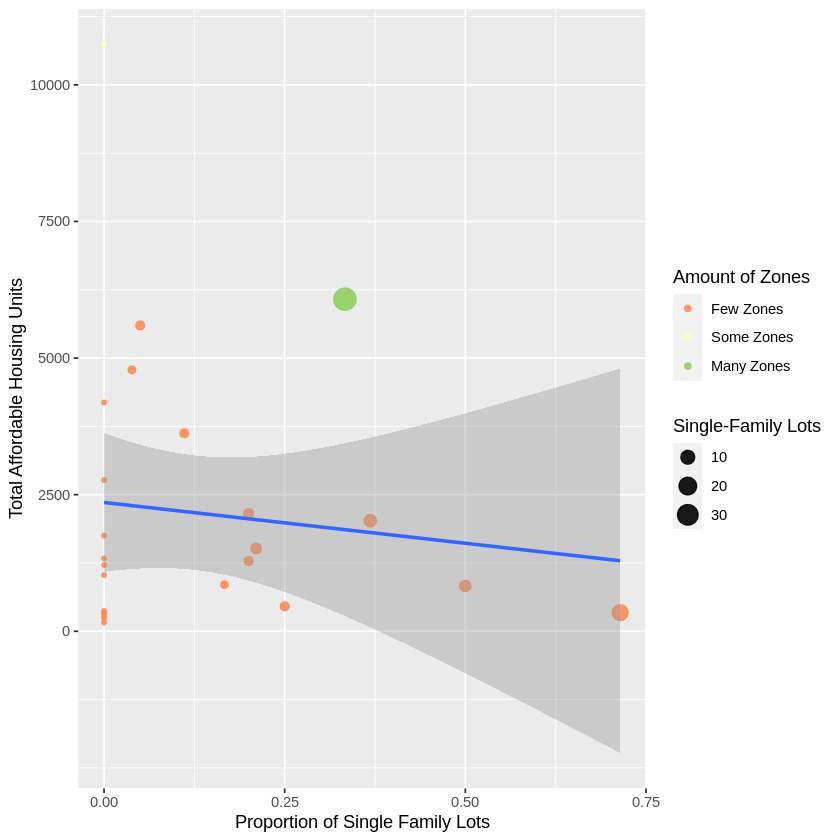

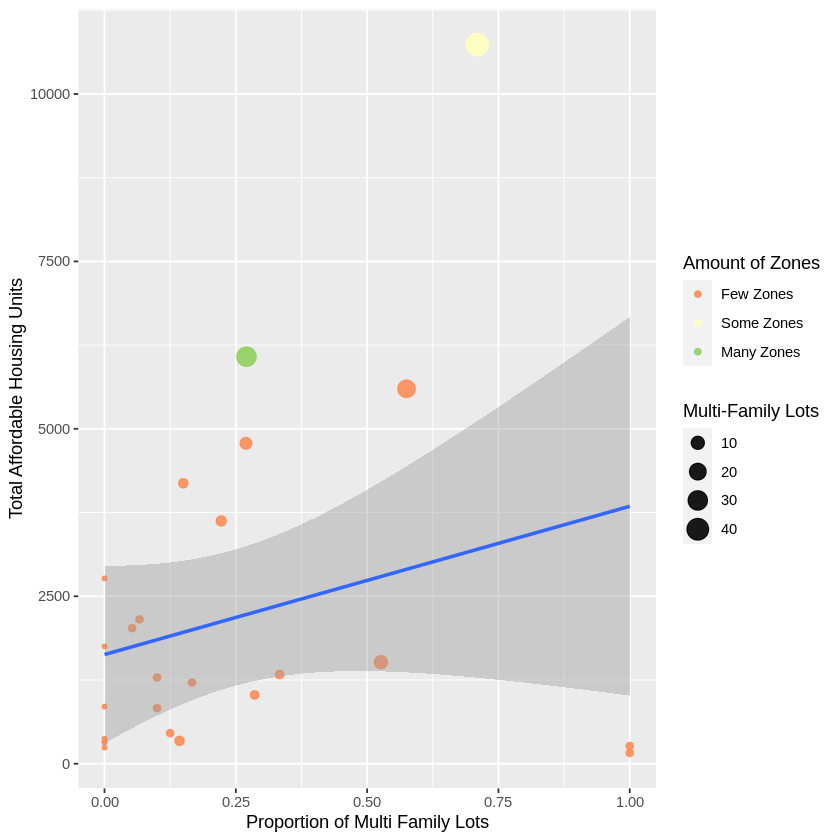

In [8]:
### Visualize with scatter plots and trendlines ###
sf_plot <- ggplot(data=main, aes(x=prop_sf, y=total_units)) +
    geom_point(aes(size=num_sf, color=zonage), alpha=0.9) +
    scale_color_brewer(palette="RdYlGn", name="Amount of Zones") +
    scale_size_continuous(breaks=c(10,20,30,40), name="Single-Family Lots") +
    scale_x_continuous(breaks = c(0, .25, .50, .75, 1.0)) +
    scale_y_continuous(breaks = c(0, 2500, 5000, 7500, 10000)) +
    geom_smooth(method='lm', formula = 'y ~ x') +
    labs(y="Total Affordable Housing Units", x="Proportion of Single Family Lots")

mf_plot <- ggplot(data=main, aes(x=prop_mf, y=total_units)) +
    geom_point(aes(size=num_mf, color=zonage), alpha=0.9) +
    scale_color_brewer(palette="RdYlGn",name="Amount of Zones") +
    scale_size_continuous(breaks=c(10,20,30,40), name="Multi-Family Lots") +
    scale_x_continuous(breaks = c(0, .25, .50, .75, 1.0)) +
    scale_y_continuous(breaks = c(0, 2500, 5000, 7500, 10000)) +
    geom_smooth(method='lm', formula = 'y ~ x') +
    labs(y="Total Affordable Housing Units", x="Proportion of Multi Family Lots")

sf_plot
mf_plot

The choropleth map helps visualize the breakdown geographically. I published the map here as Leaflet was unable to load in JupyterHub:
https://rpubs.com/micah_bruning/828122

As we can expect, the zip codes further away from the city's core have higher proportions of zones devoted to single-family housing, with a few exceptions. The zip code with the most units -- over 10,000 -- is home to the University of Texas at Austin so it's consistent that there would also be no single-family zones in this area. Overall, though, the map has mixed results -- some zip codes with relatively high proportions of single-family zones have a lot of units while others do not. 


# Conclusion

In the city of Austin, the proportion of single-family zones in a given zip-code is not a strong indicator for the total number of affordable housing units. 

The main limitation of this conclusion is that a significant amount of data was lost. In the *housing* dataframe, roughly 1,500 of the buildings' addresses had 'undisclosed' as their value so I had to filter these out. Moreover, when joining the *housing* data with the *zoning* data there were 100 records that did not match and had to be dropped. A true analysis of the city's affordable housing landscape would need the addresses of those 1,500 buildings, as well as a cleaner method of joining the datasets together (ideally by zip-code).

It's possible we'd see a stronger negative relationship between proportion of single-family zoning and total units if the data was complete. The proportion of multi-family units' positive, although weak, relationship with total units suggests that zoning proportion may be some indicator for housing outcomes. It's also reasonable to expect zoning in general to play a large role in how easily affordable housing can be developed. 